In [21]:
from reduction import *
from stack import * 
from psfstack import *

data_maps = {1: image_reduction(1), 2: image_reduction(2)}

inst = 1
psfdata_in = stack_psf(inst, data_maps[inst].stackmapdat,
                m_min=4, m_max=9, Nsub_single=True, savedata=False)
psfdata_mid = stack_psf(inst, data_maps[inst].stackmapdat,
                m_min=13, m_max=14, Nsub_single=True, savedata=False)
for ifield in [4,5,6,7,8]:
    run_psf_synth(inst,ifield)

inst = 2
psfdata_in = stack_psf(inst, data_maps[inst].stackmapdat,
                m_min=4, m_max=9, Nsub_single=True, savedata=False)
psfdata_mid = stack_psf(inst, data_maps[inst].stackmapdat,
                m_min=13, m_max=14, Nsub_single=True, savedata=False)
for ifield in [4,5,6,7,8]:
    run_psf_synth(inst,ifield)


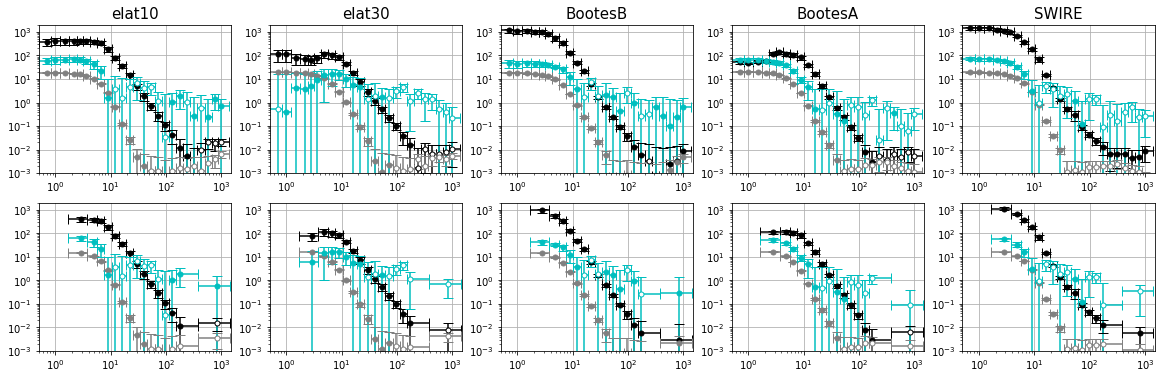

In [22]:
inst = 1
fig, ax = plt.subplots(2, 5, figsize = (20,6))
for i,ifield in enumerate([4,5,6,7,8]):
    fname = mypaths['alldat'] + 'TM'+ str(inst) + \
    '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname, "rb") as f:
        profdat = pickle.load(f)
        
    plot_err_log(profdat['rbins'], 
                 profdat['in']['profcb'],
                 profdat['in']['profcb_err'],
                 ax=ax[0][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rbins'], 
                 profdat['mid']['profcb'],
                 profdat['mid']['profcb_err'],
                 ax=ax[0][i], color='grey',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['in']['profcbsub'],
                 profdat['in']['profcbsub_err'],
                 ax=ax[1][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['mid']['profcbsub'],
                 profdat['mid']['profcbsub_err'],
                 ax=ax[1][i], color='grey',label='Source Stack')

    im = 3
    plot_err_log(profdat['rbins'], 
                 profdat[im]['profcb'],
                 profdat[im]['profcb_err'],
                 ax=ax[0][i], color='c',label='Source Stack')
    plot_err_log(profdat['rsubbins'], 
                 profdat[im]['profcbsub'],
                 profdat[im]['profcbsub_err'],
                 ax=ax[1][i], color='c',label='Source Stack')

    ax[0][i].set_ylim([1e-3,2e3])
    ax[0][i].set_xlim([5e-1,1.5e3])
    ax[0][i].grid()    
    ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
    ax[1][i].set_ylim([1e-3,2e3])
    ax[1][i].set_xlim([5e-1,1.5e3])
    ax[1][i].grid()    

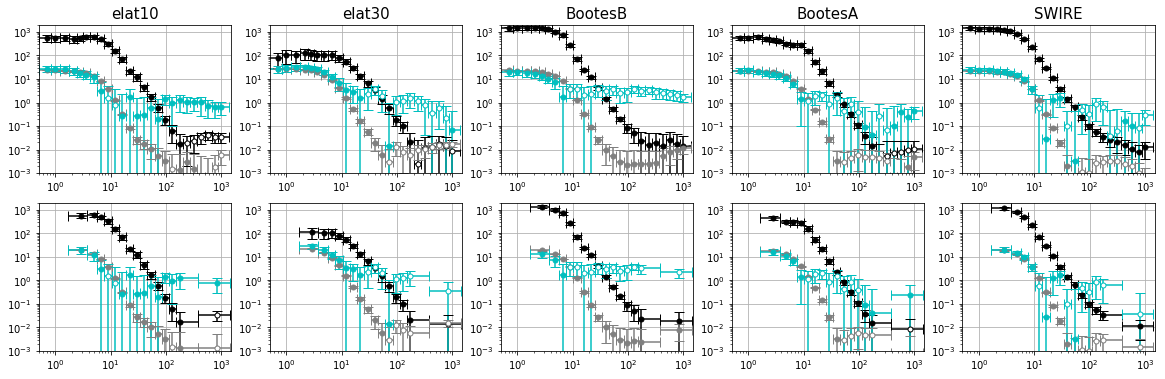

In [28]:
inst = 2
fig, ax = plt.subplots(2, 5, figsize = (20,6))
for i,ifield in enumerate([4,5,6,7,8]):
    fname = mypaths['alldat'] + 'TM'+ str(inst) + \
    '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname, "rb") as f:
        profdat = pickle.load(f)
        
    plot_err_log(profdat['rbins'], 
                 profdat['in']['profcb'],
                 profdat['in']['profcb_err'],
                 ax=ax[0][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rbins'], 
                 profdat['mid']['profcb'],
                 profdat['mid']['profcb_err'],
                 ax=ax[0][i], color='grey',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['in']['profcbsub'],
                 profdat['in']['profcbsub_err'],
                 ax=ax[1][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['mid']['profcbsub'],
                 profdat['mid']['profcbsub_err'],
                 ax=ax[1][i], color='grey',label='Source Stack')

    im = 3
    plot_err_log(profdat['rbins'], 
                 profdat[im]['profcb'],
                 profdat[im]['profcb_err'],
                 ax=ax[0][i], color='c',label='Source Stack')
    plot_err_log(profdat['rsubbins'], 
                 profdat[im]['profcbsub'],
                 profdat[im]['profcbsub_err'],
                 ax=ax[1][i], color='c',label='Source Stack')

    ax[0][i].set_ylim([1e-3,2e3])
    ax[0][i].set_xlim([5e-1,1.5e3])
    ax[0][i].grid()    
    ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
    ax[1][i].set_ylim([1e-3,2e3])
    ax[1][i].set_xlim([5e-1,1.5e3])
    ax[1][i].grid()    

In [22]:
import json
inst = 1
ifield = 6
im = 0
field = fieldnamedict[ifield]
loaddir = mypaths['alldat']+'TM' + str(inst) + '/'
with open(loaddir + field + '_datafit.json') as json_file:
    data_all = json.load(json_file)
data = data_all[im]

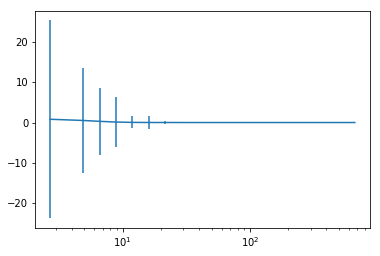

In [35]:
plt.errorbar(data['r_arr'],np.array(data['profpsfcb']),np.sqrt(np.diag(np.array(data['covpsfcb']))))
plt.xscale('log')

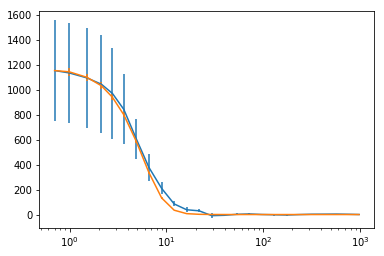

In [20]:
plt.errorbar(stackdat['rbins'],stackdat['profcb'],np.sqrt(np.diag(stackdat['cov']['profcb'])))
plt.errorbar(stackdat['rbins'],stackdat['PSF']['profcb'],np.sqrt(np.diag(stackdat['PSFcov']['profcb'])))

plt.xscale('log')

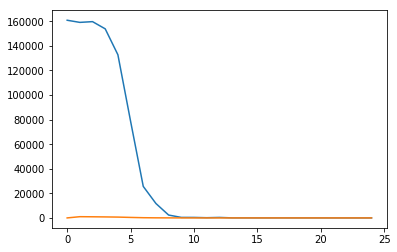

In [9]:
plt.plot(np.diag(stackdat['cov']['profcb']))
plt.plot(np.diag(stackdat['PSFcov']['profcb']))